# Visualizing Glove word embeddings

## By: Eric S. Tellez

This example creates a visualization of Glove word embeddings using `Embeddings.jl` package to fetch them.

Note: this notebook must be run with Jupyter and the environment variable JULIA_NUM_THREADS=auto, e.g., start the jupyter 

```bash
JULIA_NUM_THREADS=auto jupyter-lab .
```

_june 1st, 2023: working with `SimilaritySearch` v0.10 and `TextSearch` v0.16. I also changed from `Plots` to `Makie`._

In [1]:
using Pkg
Pkg.activate(".")

if !isfile("Manifest.toml")
    Pkg.add([
        PackageSpec(name="SimilaritySearch", version="0.10"),
        PackageSpec(name="SimSearchManifoldLearning", version="0.2"),
        PackageSpec(name="TextSearch", version="0.16"),
        PackageSpec(name="CodecZlib"),
        PackageSpec(name="CategoricalArrays"),
        PackageSpec(name="JSON"),
        PackageSpec(name="JLD2"),
        PackageSpec(name="CairoMakie"),
        PackageSpec(name="ColorSchemes"),
        PackageSpec(name="Colors"),
        PackageSpec(name="Embeddings"),
        PackageSpec(name="HypertextLiteral"),
    ])
end

using SimilaritySearch, SimSearchManifoldLearning, JLD2, CairoMakie, ColorSchemes, Colors
using LinearAlgebra, Embeddings, HypertextLiteral
using Downloads: download

  Activating project at `~/Research/SimilaritySearchDemos/Glove`
[ Info: Precompiling SimilaritySearch [053f045d-5466-53fd-b400-a066f88fe02a]
[ Info: Precompiling SimSearchManifoldLearning [ca7ab67e-1aa0-420a-90d9-eb5aef468722]
[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
[ Info: Precompiling ForwardDiffExt [4b8ca102-9d0f-5df8-84ed-253e0f005ba7]
[ Info: Precompiling Embeddings [c5bfea45-b7f1-5224-a596-15500f5db411]


# Functions to parse and vectorize texts

In [2]:
function load_dataset()
    emb = load_embeddings(GloVe{:en}, 2)  # you can change with any of the available embeddings in `Embeddings`
    for c in eachcol(emb.embeddings)
        normalize!(c)
    end

    db = MatrixDatabase(emb.embeddings)
    db, emb.vocab
end

function create_index(db)
    dist = NormalizedCosineDistance()
    index = SearchGraph(; dist, db, verbose=false)
    callbacks = SearchGraphCallbacks(MinRecall(0.9))
    index!(index; callbacks)
    optimize!(index, MinRecall(0.9))
    index
end


create_index (generic function with 1 method)

# Downloading the dataset, parsing and vectorizing functions

In [3]:
@time db, vocab = load_dataset()
@time index = create_index(db);

  9.361051 seconds (4.55 M allocations: 2.867 GiB, 5.85% gc time, 8.18% compilation time)
 11.983083 seconds (8.03 M allocations: 516.078 MiB, 2.50% gc time, 35.89% compilation time)


In [4]:
vocab2id = Dict(w => i for (i, w) in enumerate(vocab));

In [5]:
function search_and_display(index, vocab, q, res, k, qword)
    res = reuse!(res, k)
    @time search(index, q, res)

    L = []
    for (j, p) in enumerate(res)
        push!(L, @htl "<tr><td>$j</td><td>$(vocab[p.id])</td><td>$(p.id)</td><td>$(round(p.weight, digits=3))</td></tr>")
    end

    display(@htl """<h2>result list for "$qword"</h2>
    <table>
    <th>  <td>word</td> <td>id</td> <td>dist</td> </th>
        $L
    </table>
    """)
end

function search_and_display(index, vocab, qid::Integer, res, k=maxlength(res))
    search_and_display(index, vocab, index[qid], res, k, vocab[qid])
end

display(@htl "<h1>Search examples (random)</h1>")
res = KnnResult(7)
for i in 1:3
    for qid in rand(1:length(vocab))
        search_and_display(index, vocab, qid, res)
    end
end
    


<h1>Search examples (random)</h1>

  0.001777 seconds (2 allocations: 32 bytes)


1,jonrowe,157159,0.0
2,deedee,104338,0.378
3,appleman,183959,0.46
4,boge,369967,0.462
5,alders,132822,0.485
6,dulac,158793,0.489
7,goertzen,252693,0.492


  0.000446 seconds (2 allocations: 32 bytes)


1,cybercriminals,266338,-0.0
2,chicanas,364096,0.251
3,geocachers,292698,0.257
4,videophiles,315404,0.26
5,pyrotechnicians,365980,0.264
6,plagiarists,352126,0.266
7,handloaders,394621,0.266


  0.000455 seconds (2 allocations: 32 bytes)


1,escartin,127927,0.0
2,beloki,76466,0.36
3,xaus,168725,0.365
4,hviid,340397,0.37
5,servia,70379,0.378
6,zubeldia,136671,0.387
7,rodiles,179825,0.392


# Queries by word

The dataset is accessed by id, therefore we need to retrieve the id before solving queries

In [6]:
search_and_display(index, vocab, vocab2id["glove"], res, 15)

  0.000520 seconds (2 allocations: 32 bytes)


1,glove,10923,0.0
2,ball,1084,0.369
3,gloves,10808,0.369
4,plate,4365,0.379
5,pads,15978,0.418
6,infield,16731,0.435
7,bounced,9154,0.435
8,hat,5626,0.438
9,bat,4926,0.439
10,fielder,10241,0.447
11,pitch,3099,0.45


# Solving analogies

In [7]:
function analogy(a, b, c, k)
	v = index[vocab2id[a]] - index[vocab2id[b]] + index[vocab2id[c]]
	normalize!(v)
	search_and_display(index, vocab, v, res, k, "<$a> - <$b> + <$c>")
end

analogy("father", "man", "woman", 5)
analogy("fireman", "man", "woman", 5)
analogy("policeman", "man", "woman", 5)
analogy("mississippi", "usa", "france", 5)

  0.000561 seconds (2 allocations: 32 bytes)


1,mother,809,0.098
2,daughter,1132,0.132
3,wife,703,0.147
4,father,630,0.148
5,husband,1328,0.172


  0.000878 seconds (2 allocations: 32 bytes)


1,fireman,27345,0.156
2,firefighter,15812,0.303
3,paramedic,33841,0.393
4,rescuer,44915,0.439
5,passerby,53776,0.459


  0.000497 seconds (2 allocations: 32 bytes)


1,policeman,6857,0.144
2,wounding,6118,0.285
3,policemen,4984,0.295
4,passerby,53776,0.306
5,wounded,1392,0.331


  0.001489 seconds (2 allocations: 32 bytes)


1,france,388,0.468
2,rhine,13957,0.488
3,coast,955,0.506
4,brittany,15877,0.506
5,southern,483,0.506


# Visualization

## Functions to create low dimensional projections

In [8]:
function umap_embeddings(index, db; k=20, n_epochs=100, neg_sample_rate=5, tol=1e-3, layout=SpectralLayout())
    #layout = RandomLayout()
    # increase both `n_epochs` and `neg_sample_rate` to improve projection
    #layout = SpectralLayout() ## the results are much better with Spectral layout
    @time U2 = fit(UMAP, index; k, neg_sample_rate, layout, n_epochs, tol) 
    @time U3 = fit(U2, 3; neg_sample_rate, n_epochs, tol)  # reuses U2
    #jldsave(umapfile, e2=U2.embedding, e3=U3.embedding)
    if length(index) == length(db)
        e2 = predict(U2)
        e3 = predict(U3)
    else
        @time e2 = clamp.(predict(U2, db), -10f0, 10f0)
        @time e3 = clamp.(predict(U3, db), -10f0, 10f0)
    end
    (; e2, e3)
end

function normcolors(V)
    min_, max_ = extrema(V)
    V .= (V .- min_) ./ (max_ - min_)
    V .= clamp.(V, 0, 1)
end


normcolors (generic function with 1 method)

UMAP projection can take a while, even on multithreading systems. Note that we are creating 2d and 3d projections

In [9]:
#uindex = create_index(rand(db, 30000))
@time e2, e3 = umap_embeddings(index, db);

  9.420142 seconds (400.11 k allocations: 67.421 MiB, 1.17% gc time)


*** computing graph
*** layout embedding SpectralLayout
┌ Info: OutOfMemoryError()
└ Error encountered in spectral_layout; defaulting to random layout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 2.097385598
- embedding init: 0.408322321
- embedding opt: 15.506136243


 27.785993 seconds (1.00 M allocations: 1.165 TiB, 0.87% gc time, 2.42% compilation time)


 20.463285 seconds (1.79 k allocations: 10.754 MiB, 1.50% gc time)
 58.217285 seconds (14.60 M allocations: 1.166 TiB, 2.08% gc time, 18.27% compilation time)


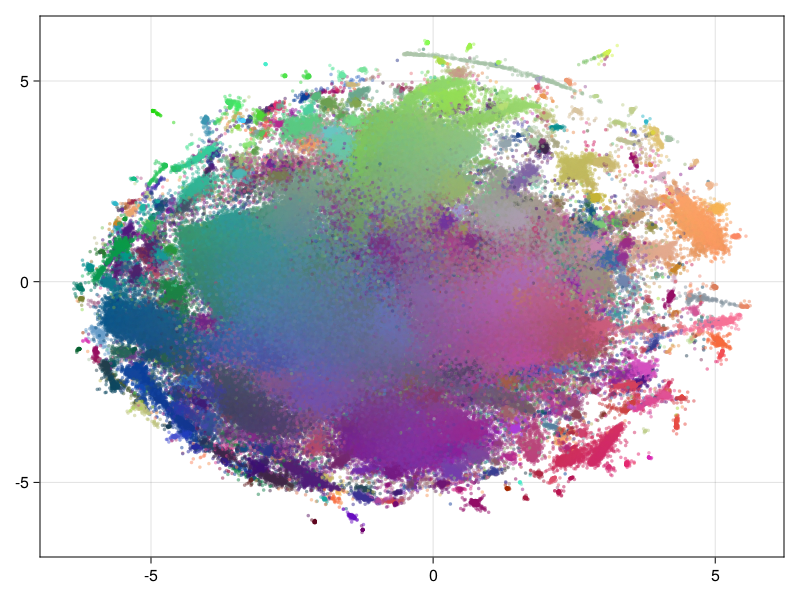

In [10]:
function plot_umap(e2, e3)
    normcolors(@view e3[1, :])
    normcolors(@view e3[2, :])
    normcolors(@view e3[3, :])

    C = [RGBAf(c[1], c[2], c[3], 0.5) for c in eachcol(e3)]
    X = @view e2[1, :]
    Y = @view e2[2, :]
    scatter(X, Y, color=C, markersize=5)
end

#=f = Figure(resolution = (800, 800))
ax = Axis(f[1,1], title = "Emoji's visualization", aspect = DataAspect())
hexbin!(ax, (@view e2[1, :]), (@view e2[2, :]); bins=200)
plot_umap(ax, e2, e3)
f
=#

plot_umap(e2, e3)

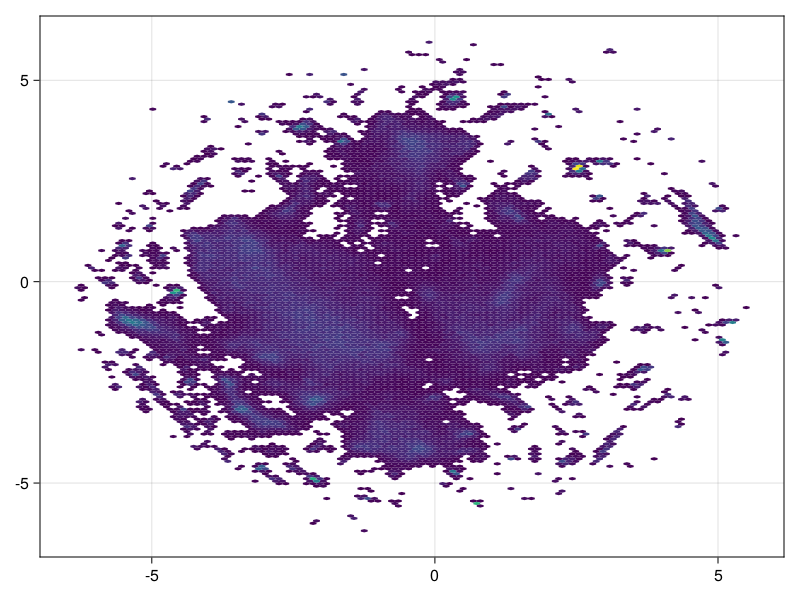

In [13]:
hexbin((@view e2[1, :]), (@view e2[2, :]); bins=200, threshold=15)

# Final notes

This example shows how to index and search dense vector databases, in particular GloVe word embeddings using the cosine distance. Low dimensional projections are made with `SimSearchManifoldLearning`, note that `SimilaritySearch` is also used for computing the all $k$ nearest neighbors needed by the UMAP model. Note that this notebook should be ran with several threads to reduce time costs.

The precise packages used in this example are listed below

In [12]:
Pkg.status()

Status `~/Research/SimilaritySearchDemos/Glove/Project.toml`
  [13f3f980] CairoMakie v0.10.5
  [324d7699] CategoricalArrays v0.10.8
  [944b1d66] CodecZlib v0.7.1
  [35d6a980] ColorSchemes v3.21.0
  [5ae59095] Colors v0.12.10
  [c5bfea45] Embeddings v0.4.2
  [ac1192a8] HypertextLiteral v0.9.4
  [033835bb] JLD2 v0.4.31
  [682c06a0] JSON v0.21.4
  [ca7ab67e] SimSearchManifoldLearning v0.2.8
  [053f045d] SimilaritySearch v0.10.8
  [7f6f6c8a] TextSearch v0.16.2
